In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Load Demand/Energy_data2.csv')
data.head()

,Year,Residential,Commercial,Industrial,Total
0,2008,7910.08,3852.0,1502.5,13264.55
1,2009,8075.00,3865.5,1585.0,13525.50
2,2020,8205.20,3925.8,1589.4,13720.40
3,2011,8285.60,4004.7,1615.5,13905.80
4,2012,8350.00,4025.4,1648.0,14023.40


In [ ]:
data.isnull().sum()

Year           0
Residential    0
Commercial     0
Industrial     0
Total          0
dtype: int64

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Prepare the energy consumption data
data = {
    'Year': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
    'Residential': [7910.08, 8075.00, 8205.20, 8285.60, 8350.00, 8773.13, 8933.23, 9093.33, 9253.43, 9413.53, 9573.63],
    'Commercial': [3852.00, 3865.50, 3925.80, 4004.70, 4025.40, 4424.78, 4542.21, 4659.64, 4777.07, 4894.50, 5011.93],
    'Industrial': [1502.50, 1585.00, 1589.40, 1615.50, 1648.00, 1615.08, 1617.73, 1620.38, 1623.03, 1625.68, 1628.33]
}

# Convert data to a Pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data for each sector separately
scalers = {}
for sector in ['Residential', 'Commercial', 'Industrial']:
    scaler = MinMaxScaler()
    df[sector + '_scaled'] = scaler.fit_transform(df[[sector]])
    scalers[sector] = scaler

# Step 3: Create input and output sequences for LSTM for each sector
look_back = 3  # Use the last 3 years' data to predict the next year
sectors = ['Residential', 'Commercial', 'Industrial']

X = {sector: [] for sector in sectors}
y = {sector: [] for sector in sectors}

for i in range(len(df) - look_back):
    for sector in sectors:
        X[sector].append(df[sector + '_scaled'].values[i:i + look_back])
        y[sector].append(df[sector + '_scaled'].values[i + look_back])

for sector in sectors:
    X[sector] = np.array(X[sector])
    y[sector] = np.array(y[sector])

    # Reshape the input data for LSTM (samples, time steps, features)
    X[sector] = np.reshape(X[sector], (X[sector].shape[0], X[sector].shape[1], 1))

# Step 4: Build the LSTM models for each sector
models = {}

for sector in sectors:
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    models[sector] = model

# Step 5: Train the LSTM models for each sector
epochs = 100
batch_size = 1

for sector in sectors:
    models[sector].fit(X[sector], y[sector], epochs=epochs, batch_size=batch_size, verbose=2)

# Step 6: Forecast energy consumption for each sector for the years 2019 to 2030
forecast_horizon = 12  # 2019 to 2030 (inclusive)
forecast = {sector: [] for sector in sectors}

for sector in sectors:
    last_sequence = X[sector][-1]  # Last 3 years' data in the training set

    for _ in range(forecast_horizon):
        # Predict the next year's consumption for each sector and update the input sequence
        next_year = models[sector].predict(last_sequence.reshape(1, look_back, 1))
        forecast[sector].append(next_year[0, 0])
        last_sequence = np.append(last_sequence[1:], next_year)

# Inverse transform the forecasted values to the original scale for each sector
forecast_residential = scalers['Residential'].inverse_transform(np.array(forecast['Residential']).reshape(-1, 1))
forecast_commercial = scalers['Commercial'].inverse_transform(np.array(forecast['Commercial']).reshape(-1, 1))
forecast_industrial = scalers['Industrial'].inverse_transform(np.array(forecast['Industrial']).reshape(-1, 1))

# Create a DataFrame with forecasted consumption for each sector for the years 2019 to 2030
forecast_years = range(2019, 2031)
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Forecasted_Residential_Energy_Consumption': forecast_residential.flatten(),
    'Forecasted_Commercial_Energy_Consumption': forecast_commercial.flatten(),
    'Forecasted_Industrial_Energy_Consumption': forecast_industrial.flatten()
})

# Save the forecasted consumption data to a CSV file
forecast_csv_filename = 'energy_consumption_forecast.csv'
forecast_df.to_csv(forecast_csv_filename, index=False)

print("Forecasted energy consumption data saved to:", forecast_csv_filename)


Epoch 1/100
8/8 - 2s - loss: 0.4815 - 2s/epoch - 293ms/step
Epoch 2/100
8/8 - 0s - loss: 0.3765 - 38ms/epoch - 5ms/step
Epoch 3/100
8/8 - 0s - loss: 0.2969 - 28ms/epoch - 3ms/step
Epoch 4/100
8/8 - 0s - loss: 0.2211 - 29ms/epoch - 4ms/step
Epoch 5/100
8/8 - 0s - loss: 0.1530 - 25ms/epoch - 3ms/step
Epoch 6/100
8/8 - 0s - loss: 0.0919 - 29ms/epoch - 4ms/step
Epoch 7/100
8/8 - 0s - loss: 0.0394 - 29ms/epoch - 4ms/step
Epoch 8/100
8/8 - 0s - loss: 0.0182 - 42ms/epoch - 5ms/step
Epoch 9/100
8/8 - 0s - loss: 0.0140 - 41ms/epoch - 5ms/step
Epoch 10/100
8/8 - 0s - loss: 0.0138 - 36ms/epoch - 5ms/step
Epoch 11/100
8/8 - 0s - loss: 0.0127 - 35ms/epoch - 4ms/step
Epoch 12/100
8/8 - 0s - loss: 0.0109 - 32ms/epoch - 4ms/step
Epoch 13/100
8/8 - 0s - loss: 0.0104 - 31ms/epoch - 4ms/step
Epoch 14/100
8/8 - 0s - loss: 0.0097 - 33ms/epoch - 4ms/step
Epoch 15/100
8/8 - 0s - loss: 0.0094 - 33ms/epoch - 4ms/step
Epoch 16/100
8/8 - 0s - loss: 0.0088 - 32ms/epoch - 4ms/step
Epoch 17/100
8/8 - 0s - loss: 0.0

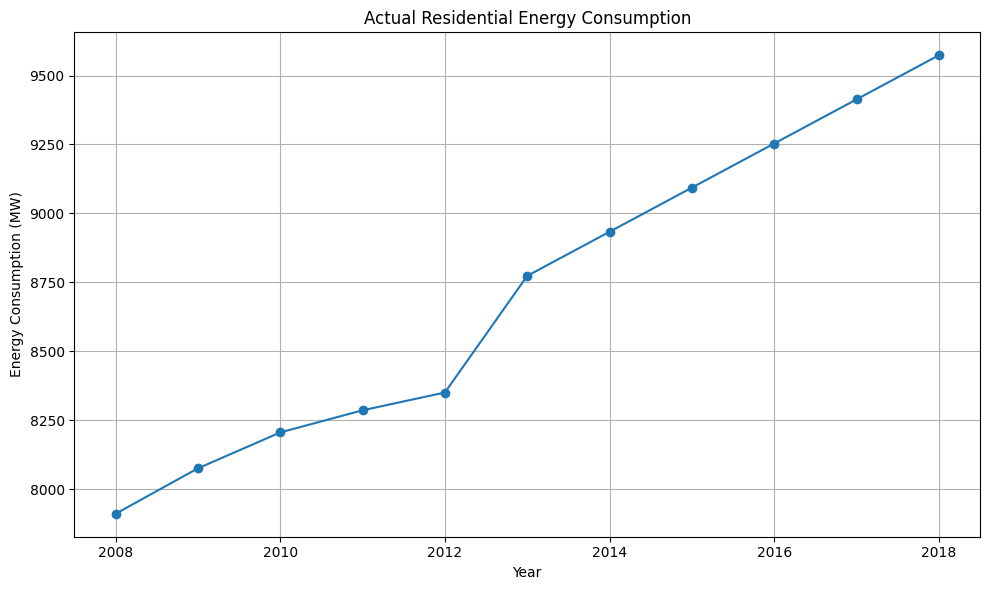

Graph saved as: residential_energy_consumption.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = {
    'Year': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
    'Residential': [7910.08, 8075.00, 8205.20, 8285.60, 8350.00, 8773.13, 8933.23, 9093.33, 9253.43, 9413.53, 9573.63]
}

df = pd.DataFrame(data)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Residential'], marker='o')
plt.title('Actual Residential Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()

# Save the graph as an image file (e.g., PNG)
output_image_filename = 'residential_energy_consumption.png'
plt.savefig(output_image_filename)

plt.show()
print("Graph saved as:", output_image_filename)


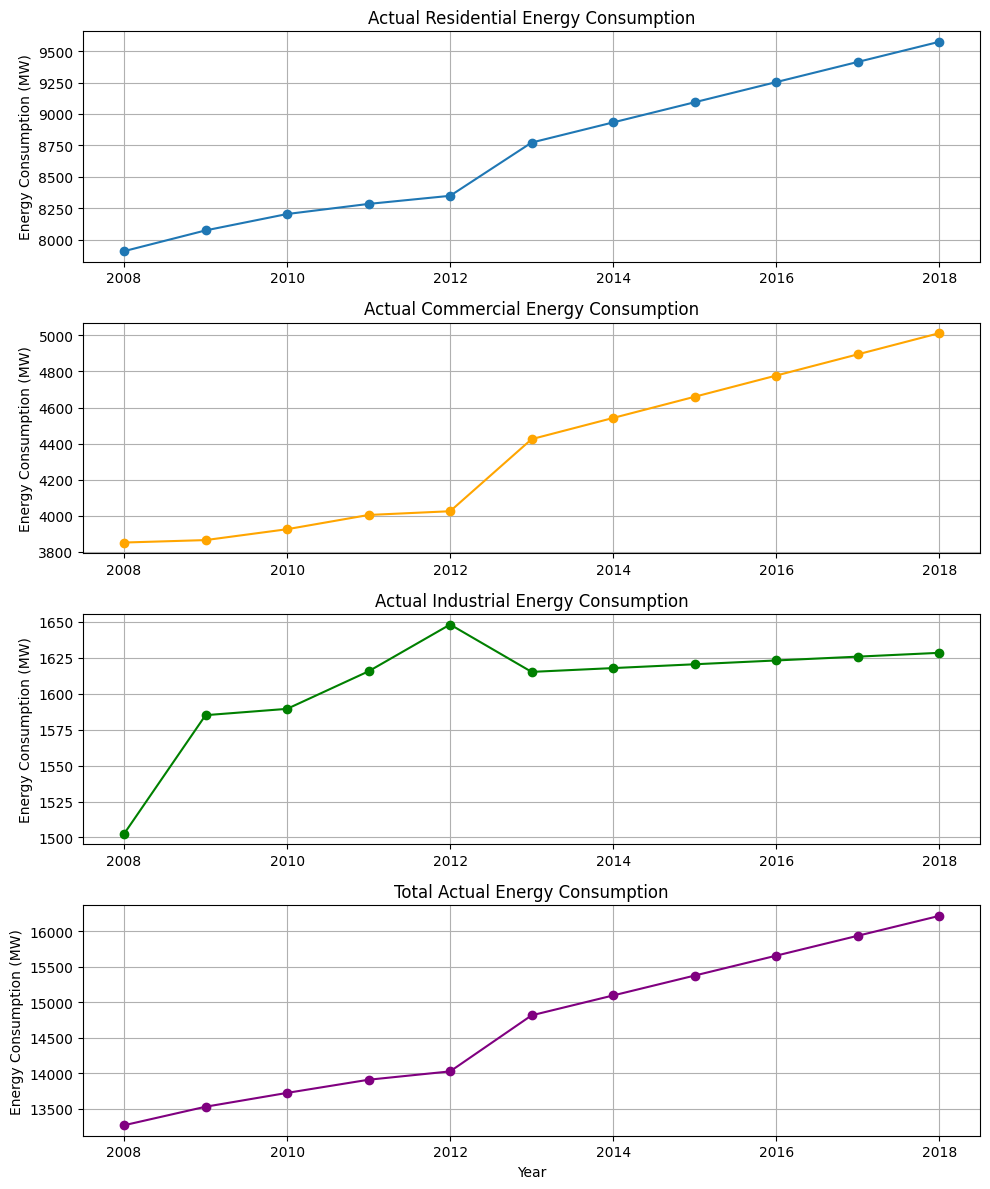

Graphs saved as: energy_consumption_actual_values.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = {
    'Year': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
    'Residential': [7910.08, 8075.00, 8205.20, 8285.60, 8350.00, 8773.13, 8933.23, 9093.33, 9253.43, 9413.53, 9573.63],
    'Commercial': [3852.00, 3865.50, 3925.80, 4004.70, 4025.40, 4424.78, 4542.21, 4659.64, 4777.07, 4894.50, 5011.93],
    'Industrial': [1502.50, 1585.00, 1589.40, 1615.50, 1648.00, 1615.08, 1617.73, 1620.38, 1623.03, 1625.68, 1628.33],
}

df = pd.DataFrame(data)

# Calculate total energy demand
df['Total'] = df['Residential'] + df['Commercial'] + df['Industrial']

# Plotting the graphs
plt.figure(figsize=(10, 12))

# Residential Energy Consumption
plt.subplot(4, 1, 1)
plt.plot(df['Year'], df['Residential'], marker='o')
plt.title('Actual Residential Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)

# Commercial Energy Consumption
plt.subplot(4, 1, 2)
plt.plot(df['Year'], df['Commercial'], marker='o', color='orange')
plt.title('Actual Commercial Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)

# Industrial Energy Consumption
plt.subplot(4, 1, 3)
plt.plot(df['Year'], df['Industrial'], marker='o', color='green')
plt.title('Actual Industrial Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)

# Total Energy Consumption
plt.subplot(4, 1, 4)
plt.plot(df['Year'], df['Total'], marker='o', color='purple')
plt.title('Total Actual Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)

plt.tight_layout()

# Save the graphs as an image file (e.g., PNG)
output_image_filename = 'energy_consumption_actual_values.png'
plt.savefig(output_image_filename)

plt.show()
print("Graphs saved as:", output_image_filename)


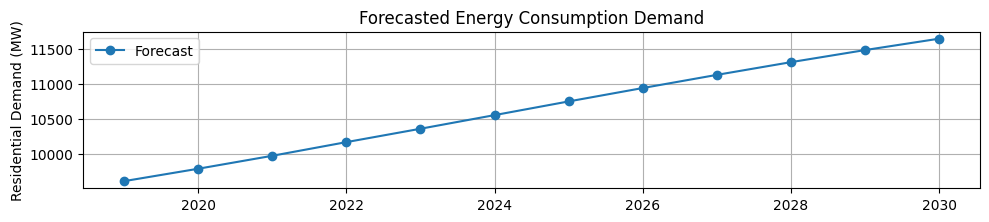

In [ ]:
import matplotlib.pyplot as plt

# Years for which we have forecasts
forecast_years = list(range(2019, 2031))

# Forecasted energy consumption demand for each sector
forecast_residential = [9608.273, 9785.714, 9970.996, 10166.48, 10357.86, 10552.86, 10748.618, 10940.259, 11128.476, 11310.292, 11483.2, 11646.181]
forecast_commercial = [5019.079, 5128.573, 5233.2505, 5331.7754, 5419.9385, 5499.959, 5571.3613, 5633.889, 5688.48, 5735.602, 5775.891, 5810.162]
forecast_industrial = [1626.2296, 1626.223, 1626.1271, 1626.0962, 1626.092, 1626.0951, 1626.0964, 1626.0967, 1626.0967, 1626.0967, 1626.0967, 1626.0967]
forecast_total = [16253.58,16540.51,16830.37,17124.35,17403.89,17678.91,17946.08,18200.24,18443.05,18671.99,18885.19,19082.44 ]

# Plotting the forecasts
plt.figure(figsize=(10, 6))

# Residential Energy Consumption Forecast
plt.subplot(3, 1, 1)
plt.plot(forecast_years, forecast_residential, marker='o', label='Forecast')
plt.title('Forecasted Energy Consumption Demand')
plt.ylabel('Residential Demand (MW)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

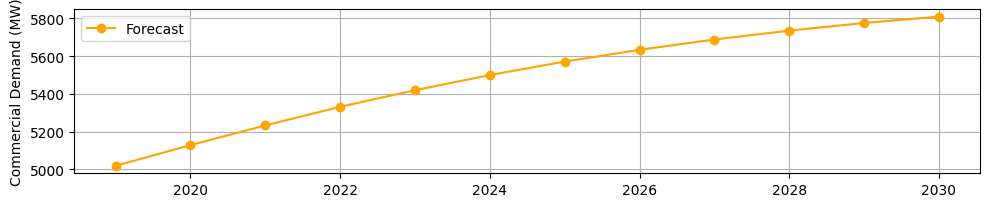

In [ ]:
# Commercial Energy Consumption Forecast
# Plotting the forecasts
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 2)
plt.plot(forecast_years, forecast_commercial, marker='o', color='orange', label='Forecast')
plt.ylabel('Commercial Demand (MW)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

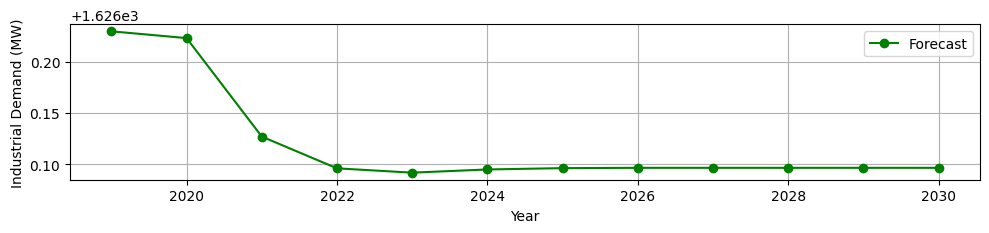

In [ ]:
# Industrial Energy Consumption Forecast
# Plotting the forecasts
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 3)
plt.plot(forecast_years, forecast_industrial, marker='o', color='green', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Industrial Demand (MW)')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

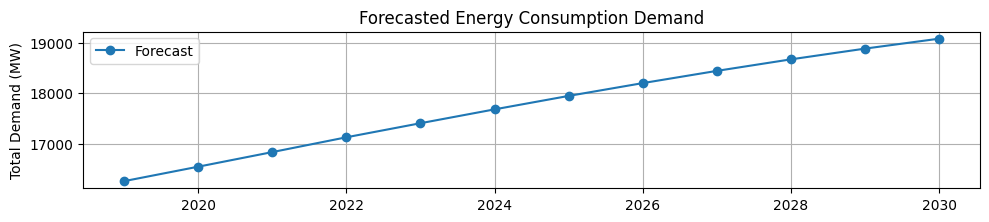

In [ ]:
# Plotting the forecasts
plt.figure(figsize=(10, 6))

# Residential Energy Consumption Forecast
plt.subplot(3, 1, 1)
plt.plot(forecast_years, forecast_total, marker='o', label='Forecast')
plt.title('Forecasted Energy Consumption Demand')
plt.ylabel('Total Demand (MW)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Years for which we have forecasts
forecast_years = list(range(2019, 2031))

# Forecasted energy consumption demand for each sector
forecast_residential = [9608.273, 9785.714, 9970.996, 10166.48, 10357.86, 10552.86, 10748.618, 10940.259, 11128.476, 11310.292, 11483.2, 11646.181]
forecast_commercial = [5019.079, 5128.573, 5233.2505, 5331.7754, 5419.9385, 5499.959, 5571.3613, 5633.889, 5688.48, 5735.602, 5775.891, 5810.162]
forecast_industrial = [1626.2296, 1626.223, 1626.1271, 1626.0962, 1626.092, 1626.0951, 1626.0964, 1626.0967, 1626.0967, 1626.0967, 1626.0967, 1626.0967]
forecast_total = [16253.58,16540.51,16830.37,17124.35,17403.89,17678.91,17946.08,18200.24,18443.05,18671.99,18885.19,19082.44 ]
# Plotting the forecasts
plt.figure(figsize=(10, 6))

# Residential Energy Consumption Forecast
plt.subplot(3, 1, 1)
plt.plot(forecast_years, forecast_residential, marker='o', label='Forecast')
plt.title('Forecasted Energy Consumption Demand')
plt.ylabel('Residential Demand (MW)')
plt.grid(True)
plt.legend()

# Commercial Energy Consumption Forecast
plt.subplot(3, 1, 2)
plt.plot(forecast_years, forecast_commercial, marker='o', color='orange', label='Forecast')
plt.ylabel('Commercial Demand (MW)')
plt.grid(True)
plt.legend()

# Industrial Energy Consumption Forecast
plt.subplot(3, 1, 3)
plt.plot(forecast_years, forecast_industrial, marker='o', color='green', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Industrial Demand (MW)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Forecasted energy consumption demand for each sector
forecast_residential = [9608.273, 9785.714, 9970.996, 10166.48, 10357.86, 10552.86, 10748.618, 10940.259, 11128.476, 11310.292, 11483.2, 11646.181]
forecast_commercial = [5019.079, 5128.573, 5233.2505, 5331.7754, 5419.9385, 5499.959, 5571.3613, 5633.889, 5688.48, 5735.602, 5775.891, 5810.162]
forecast_industrial = [1626.2296, 1626.223, 1626.1271, 1626.0962, 1626.092, 1626.0951, 1626.0964, 1626.0967, 1626.0967, 1626.0967, 1626.0967, 1626.0967]

# Calculate total forecasted demand
total_forecast = [res + comm + ind for res, comm, ind in zip(forecast_residential, forecast_commercial, forecast_industrial)]

# Display the total forecasted demand
for year, demand in zip(range(2019, 2031), total_forecast):
    print(f"Year: {year}, Total Demand: {demand:.2f} MW")


Year: 2019, Total Demand: 16253.58 MW
Year: 2020, Total Demand: 16540.51 MW
Year: 2021, Total Demand: 16830.37 MW
Year: 2022, Total Demand: 17124.35 MW
Year: 2023, Total Demand: 17403.89 MW
Year: 2024, Total Demand: 17678.91 MW
Year: 2025, Total Demand: 17946.08 MW
Year: 2026, Total Demand: 18200.24 MW
Year: 2027, Total Demand: 18443.05 MW
Year: 2028, Total Demand: 18671.99 MW
Year: 2029, Total Demand: 18885.19 MW
Year: 2030, Total Demand: 19082.44 MW


ValueError: ignored

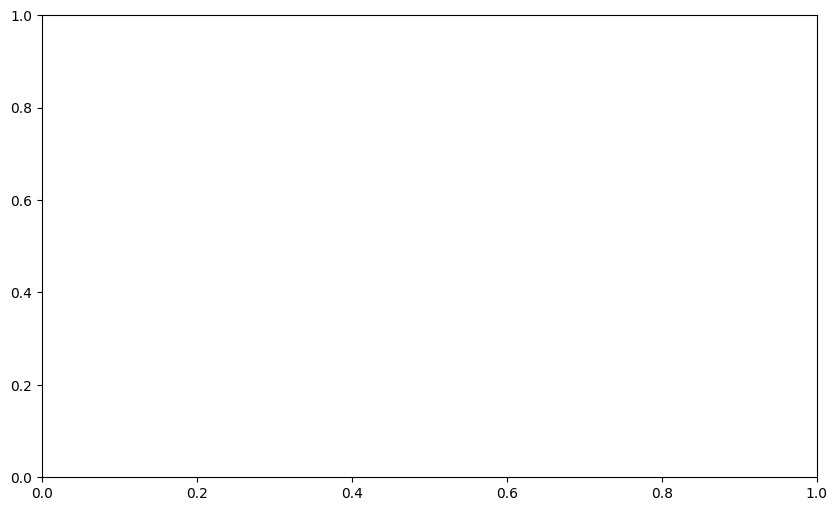

In [ ]:
import matplotlib.pyplot as plt

# Years for which we have initial and forecasted data
years = list(range(2008, 2031))

# Initial total energy consumption demand data
initial_total_demand = [13264.55, 13525.50, 13720.40, 13905.80, 14023.40, 14812.99, 15093.17, 15373.35, 15653.53, 15933.71, 16213.89, 0, 0]

# Forecasted total energy consumption demand
forecast_total_demand = [sum(forecast) for forecast in zip(forecast_residential, forecast_commercial, forecast_industrial)]

# Plotting the Initial and Forecasted Total Energy Consumption Demand
plt.figure(figsize=(10, 6))
plt.plot(years, initial_total_demand, marker='o', color='blue', label='Initial Demand')
plt.plot(years[11:], forecast_total_demand[11:], marker='o', color='orange', label='Forecasted Demand')
plt.title('Initial vs. Forecasted Total Energy Consumption Demand')
plt.xlabel('Year')
plt.ylabel('Total Demand (MW)')
plt.grid(True)
plt.legend()
plt.show()
